# SKLearn Intro

Read https://scikit-learn.org/stable/getting_started.html **fully** first of all!

## Environment / imports

In [25]:
! python -V
! pip freeze | grep -i scikit-learn

Python 3.6.9
scikit-learn==0.22.2.post1


In [1]:
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

## Big picture

### General Classes & Interfaces architecture

The `scikit-learn` library has a unified interface for all "models". It uses the very broad concept of **estimator** to roughly mean:
- a thing that takes some input data
- ...outputs some data
- ...has some internal parameters.

An **estimator** is simply defined as having methods to set and get its internal parameters.

So seemingly unrelated concepts can all be unified under the umbrella term "estimator":
- **feature transformers / encoders:** these can be used to transfer either *input data* or *training labels data* (this dual use explains some of the awkward weird interfaces of things like `OneHotEncoder`), and in general they can also performa the inverse transform
    - these have `fit`, `transform` and `inverse_transform` methods (also combined `fit_transform` for convenience/performance reasons)
- **feature scalers**
    - similar methods to transformers/encoders defined above, they have `fit`, `transform` and `inverse_transform` methods
- **classifiers** - supervised learning models for performing classification (eg. "predict the class of an input")
    - these have `fit` and `predict` methods
- **regressors** - supervised learning models for performing regression (eg. "predict a continuous value")
    - similarly, `fit` and `predict` methods
- **clusterers** - unsupervised learning models for performing clusterin
    - `fit`, `predit` and `fit_predict` (since it's an unsupervised learning task) methods 
    - also `transform` ± `fit_transform` for some clusterers, since they are usable for transforming eg. X into a different space, that of distances to cluster centers
    
The general idea though, is that `scikit-learn` does not provide these componets as *"black boxes"* - one needs to actually sit and read the docs of each in order to correctly use them, since all these methods can take in extra params and sometimes have different requirements for the types and shapes of their inputs.

The "loose standardization" serves the purpose of makind these encoders/transformers/models [**composable into pipelines**](https://scikit-learn.org/stable/modules/compose.html), not of hiding / abstracting away the implementation details. So don't view them as "leaky abstraction", but as "simplest/minimal amount of structure that enables easy composability and extension". *Adopting this mindset will save you from tons of frustration! If you are a "professinal software engineer", don't look at the abstractions in `scikit-learn` and other ML libraries as serving similar purpose to the abstractions in a large software system - they are NOT, they are intended for solving a different set of problems!*

```python
## NOTE: this *PSEUDOCODE*, *NOT Python code!*

# NOTATION:
#    ~x: type and shape similar to x

# base "models" class
class BaseEstimator:
    get_params(deep=True) -> dict
    set_params(**params) -> self

# Pre-processing - Encoding
class *Encoder(BaseEstimator):
	fit(data: array~[n_samples], ...) -> self
	transform(data) -> ~data
	fit_transform(data, ...) -> ~data
	± inverse_transform(data) -> ~data

# Pre-processing - Scaling
class *Scaler(BaseEstimator):
	fit(X, y=None, ...) -> self
	partial_fit(X, y=None) -> self
	transform(X, y='deprecated', copy=None) -> ~X
	fit_transform(X, y=None, ...) -> ~X
	inverse_transform(X, copy=None) -> ~X

# Unsupervised Learning - Classification
class *Classifier(...BaseEstimator):
	fit(X, y=None, ...) -> self
	predict(X) -> ~y
	score(X, y, ...)

# Supervised Learning - Regression
class *Regressor(...BaseEstimator):
	fit(X, y, ...) -> self
	predict(X) -> ~y
	score(X, y, ...) -> *

# Unsupervised Learning - Clustering
class *Cluster(...BaseEstimator):
	fit(X, y=None, ...) -> self
	predict(X) -> ~y
	fit_predict(X, y=None, ...) -> ~y
```

### Concepts

The ideas of "transductive" and "inductive" sound a bit esoteric, but they offer a good insight to some of the reasoning behing the library's architecture. Understanding what the words mean *will make reading the docs easier, so do take 5 min to do this!*

- **Transduction, Transductive**: A transductive (contrasted with inductive) machine learning method is designed to model a specific dataset, but not to apply that model to unseen data. Examples include manifold.TSNE, cluster.AgglomerativeClustering and neighbors.LocalOutlierFactor.
  - A purely transductive transformer, such as manifold.TSNE, may not implement `transform`, but only `fit_transform`
  - Unsupervised, transductive estimator implement `fit_predict`
- **Inductive** (contrasted with transductive): this type of machine learning builds a model of some data that can then be applied to new instances. Most estimators in Scikit-learn are inductive, having predict and/or transform methods.
  - implement `fit` and `predit` ± `transform`
  
Any other concepts used a lot in the docs are really well and succinctly explained in the docs. They're denser and faster to read than eg. the wikipedia pages for this concepts, so *make use of this when confused about a term:*
- https://scikit-learn.org/stable/glossary.html

## Pre-processing

https://scikit-learn.org/stable/modules/preprocessing.html

### Encoding - label / categorical data as numbers

**Alternative 1:** for `y` data you'll likely want to use `sklearn.preprocessing.LabelEncoder`

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
health_train = ['fit', 'slim', 'obese', 'fit', 'slim']
health_test1 = ['obese', 'obese', 'fit', 'slim']
health_test2 = ['obese', None, 'obese', 'fit', 'humungous', 'slim']
health_test3 = ['obese', 'obese', 'fit', 'humungous', 'slim']

In [29]:
label_encoder = LabelEncoder()
label_encoder.fit(health_train)
label_encoder.transform(health_train)

array([0, 2, 1, 0, 2])

In [30]:
label_encoder.transform(health_test1)

array([1, 1, 0, 2])

In [ ]:
# throw error
# label_encoder.transform(health_test2)
# label_encoder.transform(health_test3)

**Alternative 2:** for `X` data prefer `sklearn.preprocessing.OrdinalEncoder`

In [32]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()
X = [['male', 'from US', 'uses Safari'], ['female', 'from Europe', 'uses Firefox']]
enc.fit(X)
print("> X transformed:", enc.transform(X))

enc.transform([['female', 'from US', 'uses Safari']])

> X transformed: [[1. 1. 1.]
 [0. 0. 0.]]


array([[0., 1., 1.]])

### Encoding - 1-hot
NOTE: This encoder expects an actual 2D numpy array (matrix)

**Alternative 1:** `sklearn.preprocessing.LabelBinarizer` works as intuitively expected and it sort of assumes it will be used on `y` data.

In [ ]:
from sklearn.preprocessing import LabelBinarizer

In [34]:
label_binarizer = LabelBinarizer()
label_binarizer.fit_transform(health_train)

array([[1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1]])

In [35]:
label_binarizer.transform(health_test1)

array([[0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1]])

In [36]:
# works, despite unseen label "humungios" (just encodes it to all zeroes)
label_binarizer.transform(health_test3)

array([[0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 0],
       [0, 0, 1]])

In [ ]:
# throws error bc. of None label
# label_binarizer.transform(health_test2)

**Alternative 2:** `sklearn.preprocessing.OneHotEncoder` is quite fussy about its input, but it's intended to be used on `X` data so it behaves as expected for this case.

**WARNING:** The part of the `preprocessing` module relevant to this change quite a bit between `scikit-learn` versions, eg. see:
- https://scikit-learn.org/0.19/modules/preprocessing.html
- vs. https://scikit-learn.org/0.22/modules/preprocessing.html

In [38]:
sklearn_version = tuple(map(int, sklearn.__version__.split('.')[:2]))
sklearn_version

(0, 22)

In [39]:
if sklearn_version <= (0, 19):
    # --- For scikit-learn 0.19 and maybe lower:
    # In these older versions OneHotEncoder can't directly work with non-numerical data,
    # so we need to numericalize it first.
    print("--- old scikit-learn <= 0.19")
    
    from sklearn.preprocessing import LabelEncoder, OneHotEncoder

    label_encoder2 = LabelEncoder()

    health_train_num = label_encoder2.fit_transform(health_train)
    print("> health_train_num:")
    display(health_train_num)

    oh_encoder = OneHotEncoder()
    # .reshape(-1, 1) is needed to transform a 1d array in 2d one as OneHotEncoder expects
    r = oh_encoder.fit_transform(health_train_num.reshape(-1, 1)) # : scipy.sparse.csr.csr_matrix
    print("> OHE result:")
    display(r.toarray())

elif sklearn_version >= (0, 22):
    # --- For scikit-learn 0.22 and above:
    print("--- new-ish scikit-learn >= 0.22")
    
    from sklearn.preprocessing import OneHotEncoder

    oh_encoder = OneHotEncoder()
    # .reshape(-1, 1) is needed to transform a 1d array in 2d one as OneHotEncoder expects
    r = oh_encoder.fit_transform(np.array(health_train).reshape(-1, 1)) # : scipy.sparse.csr.csr_matrix
    print("> OHE result:")
    display(r.toarray())

else:
    print("--- scikit-learn > 0.19 and < 0.22: NO IDEA WHAT WORKS HERE!")

--- new-ish scikit-learn >= 0.22
> OHE result:


array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [ ]:
### Scaling - normalization

In [41]:
from sklearn.preprocessing import StandardScaler

data = [[0, 0], [0, 0], [1, 1], [1, 1]]

scaler = StandardScaler()
scaler.fit(data)

print(f"Scaler fitted params: mean={scaler.mean_}, scale={scaler.scale_}")

print("> transformed data:")
display(scaler.transform(data))

print("> transformed [[2, 2]]:")
display(scaler.transform([[2, 2]]))

Scaler fitted params: mean=[0.5 0.5], scale=[0.5 0.5]
> transformed data:


array([[-1., -1.],
       [-1., -1.],
       [ 1.,  1.],
       [ 1.,  1.]])

> transformed [[2, 2]]:


array([[3., 3.]])

### ColumnTransformer for heterogeneous data
https://scikit-learn.org/stable/modules/compose.html#columntransformer-for-heterogeneous-data

In [42]:
X = pd.DataFrame(
    {'city': ['London', 'London', 'Paris', 'Sallisaw'],
     'title': ["His Last Bow", "How the Watson Learned the Trick",
               "A Moveable Feast", "The Grapes of Wrath"],
     'expert_rating': [5, 3, 4, 5],
     'user_rating': [4, 5, 4, 3]})
X

,city,title,expert_rating,user_rating
0,London,His Last Bow,5,4
1,London,How the Watson Learned the Trick,3,5
2,Paris,A Moveable Feast,4,4
3,Sallisaw,The Grapes of Wrath,5,3


In [43]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder

column_trans = ColumnTransformer(
    [('city_category', OneHotEncoder(dtype='int'),['city']),
     ('title_bow', CountVectorizer(), 'title')],
    remainder='drop')

column_trans.fit(X)

print("> feature names:", column_trans.get_feature_names())

column_trans.transform(X).toarray()

> feature names: ['city_category__x0_London', 'city_category__x0_Paris', 'city_category__x0_Sallisaw', 'title_bow__bow', 'title_bow__feast', 'title_bow__grapes', 'title_bow__his', 'title_bow__how', 'title_bow__last', 'title_bow__learned', 'title_bow__moveable', 'title_bow__of', 'title_bow__the', 'title_bow__trick', 'title_bow__watson', 'title_bow__wrath']


array([[1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 2, 1, 1, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]], dtype=int64)

## Classification
https://scikit-learn.org/stable/supervised_learning.html#supervised-learning

Classification example dataset - iris
- https://scikit-learn.org/stable/datasets/index.html#iris-plants-dataset
- https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

In [44]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris_X, iris_y = load_iris(return_X_y=True)
iris_X_train, iris_X_test, iris_y_train, iris_y_test = \
    train_test_split(iris_X, iris_y, random_state=1, test_size=0.2)

print(f"iris_X ~ {iris_X.shape}, iris_y ~ {iris_y.shape}")
print(f"iris_X_train ~ {iris_X_train.shape}, iris_y_train ~ {iris_y_train.shape}")
print(f"iris_X_test ~ {iris_X_test.shape}, iris_y_test ~ {iris_y_test.shape}")

iris_X ~ (150, 4), iris_y ~ (150,)
iris_X_train ~ (120, 4), iris_y_train ~ (120,)
iris_X_test ~ (30, 4), iris_y_test ~ (30,)


Example: SVM model (SVC aka "Support Vector Classifier")

In [45]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svc = SVC()
svc.fit(iris_X_train, iris_y_train)

iris_y_train_predicted = svc.predict(iris_X_train)
print("> accuracy on training data:", accuracy_score(iris_y_train, iris_y_train_predicted))

iris_y_test_predicted = svc.predict(iris_X_test)
print("> accuracy on test data:", accuracy_score(iris_y_test, iris_y_test_predicted))

# NOTE: you CAN also get betteer accurracy on test than on training with this dataset
#    if you play around with this code. Reason is simply that dataset is very small,
#    and you can occassionally get an easy/lucky test set. Use larger datasets!

> accuracy on training data: 0.975
> accuracy on test data: 0.9666666666666667


## Regression
https://scikit-learn.org/stable/supervised_learning.html#supervised-learning

Regression example dataset - boston housing 
- https://scikit-learn.org/stable/datasets/index.html#boston-dataset

In [46]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

bh_X, bh_y = load_boston(return_X_y=True)
bh_X_train, bh_X_test, bh_y_train, bh_y_test = \
    train_test_split(bh_X, bh_y, random_state=1, test_size=0.2)

print(f"bh_X ~ {bh_X.shape}, bh_y ~ {bh_y.shape}")
print(f"bh_X_train ~ {bh_X_train.shape}, bh_y_train ~ {bh_y_train.shape}")
print(f"bh_X_test ~ {bh_X_test.shape}, bh_y_test ~ {bh_y_test.shape}")

bh_X ~ (506, 13), bh_y ~ (506,)
bh_X_train ~ (404, 13), bh_y_train ~ (404,)
bh_X_test ~ (102, 13), bh_y_test ~ (102,)


In [47]:
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR

svr = SVR()
svr.fit(bh_X_train, bh_y_train)

bh_y_train_predicted = svr.predict(bh_X_train)
print("> MSE on test data:", mean_squared_error(bh_y_train, bh_y_train_predicted))

bh_y_test_predicted = svr.predict(bh_X_test)
print("> MSE on test data:", mean_squared_error(bh_y_test, bh_y_test_predicted))

> MSE on test data: 63.110980896358605
> MSE on test data: 80.88313574924172


## Clustering
https://scikit-learn.org/stable/modules/clustering.html#clustering

> iris.data ~ (150, 4)
> iris.target ~ (150,)
> X_reduced ~ (150, 2)


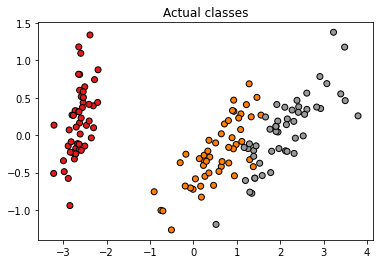

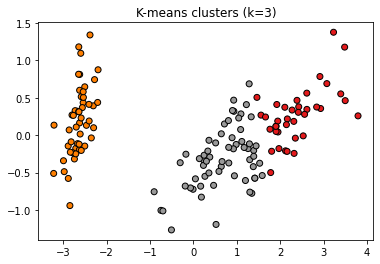

In [48]:
from sklearn.cluster import KMeans
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA

iris = load_iris()
print("> iris.data ~", iris.data.shape)
print("> iris.target ~", iris.target.shape)

kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(iris.data)

# we do PCA to reduce from 4d to 2d for vizualization
X_reduced = PCA(n_components=2).fit_transform(iris.data)
print("> X_reduced ~", X_reduced.shape)

plt.title("Actual classes")
plt.scatter(
    X_reduced[:, 0], X_reduced[:, 1],
    c=iris.target,
    cmap=plt.cm.Set1,
    edgecolor='k'
)
plt.show()
plt.title("K-means clusters (k=3)")
plt.scatter(
    X_reduced[:, 0], X_reduced[:, 1],
    c=kmeans.labels_,
    cmap=plt.cm.Set1,
    edgecolor='k'
)
plt.show()

## Pipelines
- https://scikit-learn.org/stable/getting_started.html#pipelines-chaining-pre-processors-and-estimators
- https://scikit-learn.org/stable/modules/compose.html#pipeline-chaining-estimators

Why:
1. easier to structure your code in readable and extensible ways
2. prevent you from accidentally contaminating your model with infos from test data (eg. when doing cross validation, by doing it on a pipeline that includes a scaler, instead of doing the scaling on all data first and then cross-validating the model, training data handling is not influenced by properties like mean and variance of thee whole-dataset-including-test)

In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# create a pipeline object
pipe = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(random_state=42)
)

# load the iris dataset and split it into train and test sets
iris_X, iris_y = load_iris(return_X_y=True)
iris_X_train, iris_X_test, iris_y_train, iris_y_test = \
    train_test_split(iris_X, iris_y, random_state=1, test_size=0.2)

# fit the whole pipeline
pipe.fit(iris_X_train, iris_y_train)

iris_y_train_predicted = pipe.predict(iris_X_train)
print("> accuracy on training data:", accuracy_score(iris_y_train, iris_y_train_predicted))

iris_y_test_predicted = pipe.predict(iris_X_test)
print("> accuracy on test data:", accuracy_score(iris_y_test, iris_y_test_predicted))

> accuracy on training data: 1.0
> accuracy on test data: 0.9666666666666667


## Model selection and evaluation
https://scikit-learn.org/stable/model_selection.html#model-selection

### Hyper-parameters tuning - randomized search

In [50]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# load the iris dataset and split it into train and test sets
iris_X, iris_y = load_iris(return_X_y=True)
iris_X_train, iris_X_test, iris_y_train, iris_y_test = \
    train_test_split(iris_X, iris_y, random_state=1, test_size=0.2)

# create a pipeline object
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('rfc', RandomForestClassifier(random_state=42)),
])

# define the parameter space that will be searched over
param_distributions = {'rfc__n_estimators': randint(1, 5),
                       'rfc__max_depth': randint(5, 10)}

# now create a searchCV object and fit it to the data
# (this will behave like the estimator (model or pipeline) it wraps)
search = RandomizedSearchCV(estimator=pipe,
                            n_iter=5,
                            param_distributions=param_distributions,
                            random_state=0)

# fit the whole pipeline
search.fit(iris_X_train, iris_y_train)

print("> searchCV best params:", search.best_params_)

iris_y_train_predicted = search.predict(iris_X_train)
print("> accuracy on training data:", accuracy_score(iris_y_train, iris_y_train_predicted))

iris_y_test_predicted = search.predict(iris_X_test)
print("> accuracy on test data:", accuracy_score(iris_y_test, iris_y_test_predicted))

> searchCV best params: {'rfc__max_depth': 9, 'rfc__n_estimators': 4}
> accuracy on training data: 0.975
> accuracy on test data: 0.9666666666666667
